In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with = engine)

In [7]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [10]:
# Find the most recent date in the data set.
recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]
print(recent_date)

2017-08-23


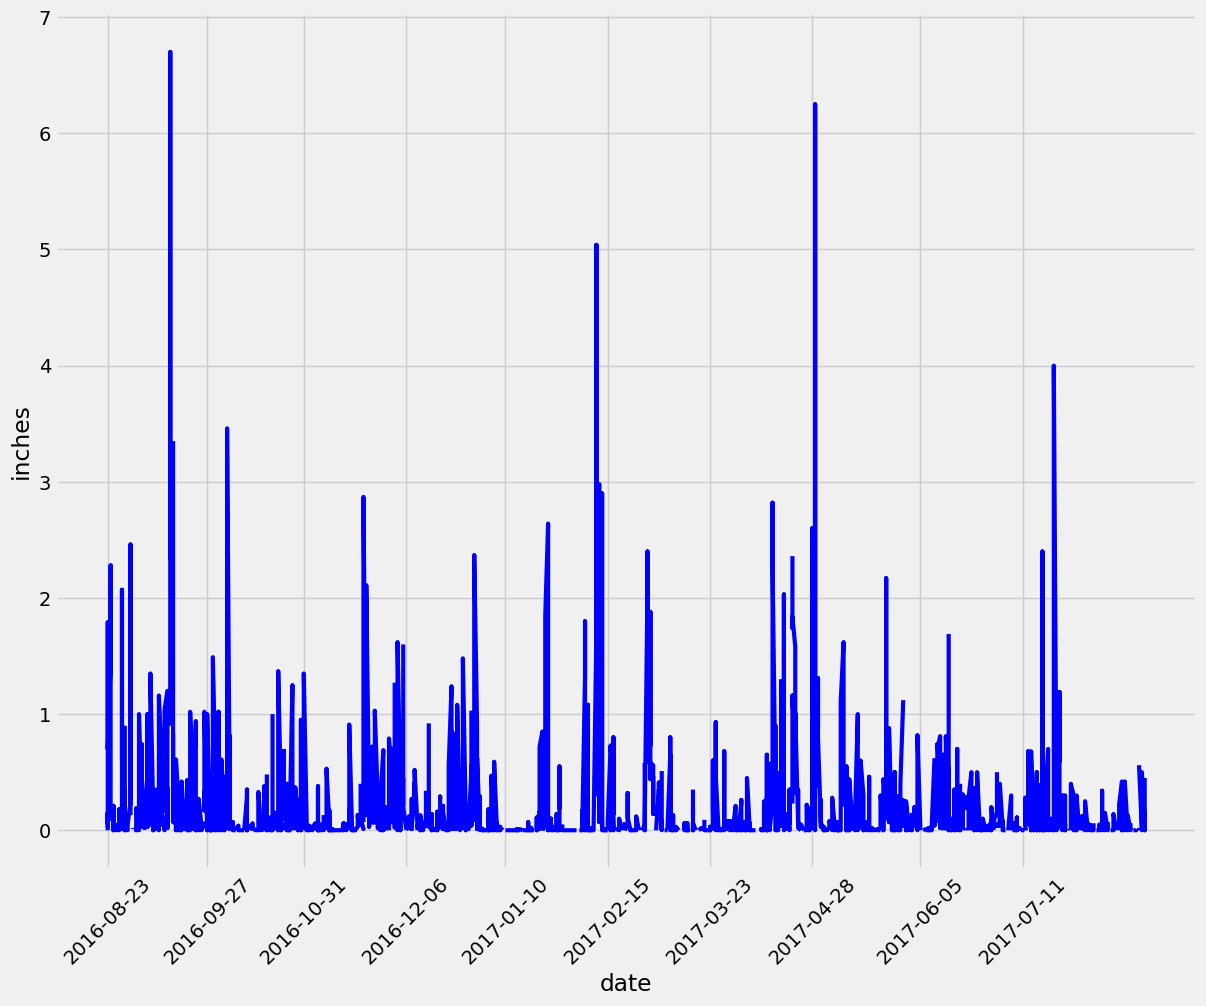

In [17]:
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt

# Calculate the date one year from the last date in the dataset
one_year_ago = dt.date(2017, 8, 23) - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
results = session.query(Measurement.date, Measurement.prcp).order_by(Measurement.date.asc()).\
        filter(Measurement.date >= one_year_ago).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
df_results = pd.DataFrame(results)
df_results = df_results.rename(columns={"prcp": "precipitation"})
df_results['date'] = pd.to_datetime(df_results['date'])

# Sort the dataframe by date
df_results.sort_values(by='date', ascending=True, inplace=True)

# Use Pandas Plotting with Matplotlib to plot the data
plt.figure(figsize=(12, 10))
plt.plot(df_results['date'], df_results['precipitation'], color='b', linewidth=3.0)

# Set x-axis tick positions and labels
plt.xticks(rotation=45)
plt.gca().set_xticks(df_results['date'][::len(df_results)//10])  # Set ticks at approximately even intervals

plt.tight_layout()
plt.ylabel("inches")
plt.xlabel("date")
plt.grid(True)
plt.show()



In [21]:
# Use Pandas to calculate the summary statistics for the precipitation data
prcp_df = df_results['precipitation'].describe()
prcp_df

count    2021.000000
mean        0.177279
std         0.461190
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: precipitation, dtype: float64

# Exploratory Station Analysis

In [22]:
# Design a query to calculate the total number of stations in the dataset
station_count=session.query(func.count(Station.id)).all()
station_count

[(9,)]

In [23]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
station_Measurment_join=session.query(Measurement.station,func.count(Measurement.station)).\
                       group_by(Measurement.station).\
                       order_by(func.count(Measurement.station).desc()).all()
station_Measurment_join

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [24]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
results_temp=session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
             filter(Measurement.station==station_Measurment_join[0][0]).all()
results_temp

[(54.0, 85.0, 71.66378066378067)]

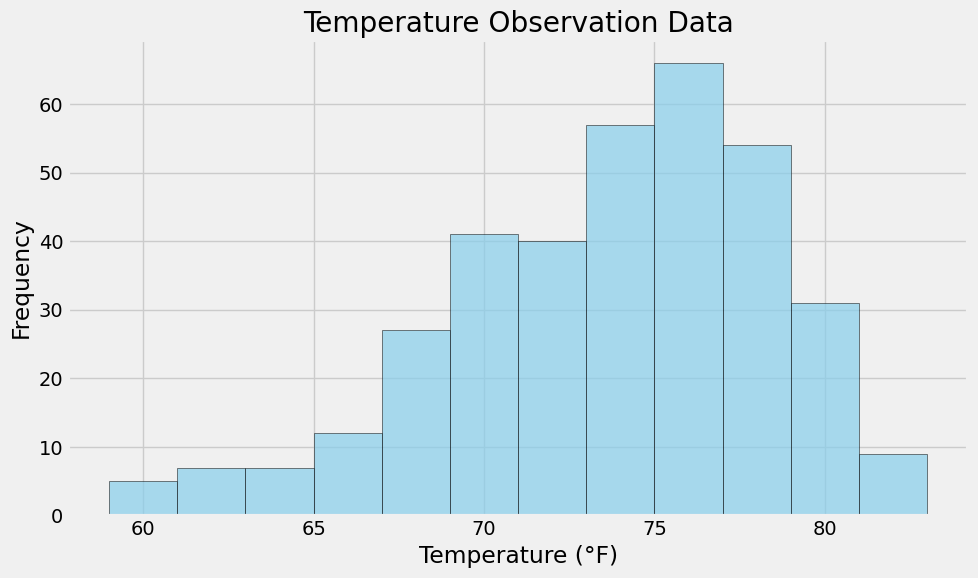

In [25]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
station_with_most_observations = session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).first()[0]

# Calculate the date one year ago from the last data point in the database
latest_date = session.query(func.max(Measurement.date)).filter(Measurement.station == station_with_most_observations).scalar()
year_back = dt.datetime.strptime(latest_date, "%Y-%m-%d") - dt.timedelta(days=365)

results_temp = session.query(Measurement.tobs).filter(Measurement.station == station_with_most_observations).\
    filter(Measurement.date >= year_back).all()

# Create a DataFrame from the TOBS data
df_results = pd.DataFrame(results_temp)

# Plot the results as a histogram with bins=12
plt.figure(figsize=(10, 6))
plt.hist(df_results['tobs'], bins=12, color='skyblue', edgecolor='black', alpha=0.7)
plt.title('Temperature Observation Data')
plt.xlabel('Temperature (°F)')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()

# Close Session

In [26]:
# Close Session
session.close()